# Getfem++を使用した地盤の線形時刻歴応答解析

Getfem++を使用して地盤の２次元線形時刻歴応答解析を行いました。

In [1]:
import numpy as np
import getfem as gf
import pylab as plt

## 支配方程式
まずは支配方程式であるNavierの式をおさらいします。

$\left(\lambda+\mu\right)\dfrac{\partial}{\partial x}\left(\dfrac{\partial u_{x}}{\partial x}+\dfrac{\partial u_{y}}{\partial y}+\dfrac{\partial u_{z}}{\partial z}\right)+\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial y^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{x}+f_{x}=\rho\dfrac{\partial^{2}u_{x}}{\partial t^{2}}$
$\left(\lambda+\mu\right)\dfrac{\partial}{\partial y}\left(\dfrac{\partial u_{x}}{\partial x}+\dfrac{\partial u_{y}}{\partial y}+\dfrac{\partial u_{z}}{\partial z}\right)+\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial y^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{y}+f_{y}  =  \rho\dfrac{\partial^{2}u_{y}}{\partial t^{2}}$
$\left(\lambda+\mu\right)\dfrac{\partial}{\partial z}\left(\dfrac{\partial u_{x}}{\partial x}+\dfrac{\partial u_{y}}{\partial y}+\dfrac{\partial u_{z}}{\partial z}\right)+\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial y^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{z}+f_{z}  =  \rho\dfrac{\partial^{2}u_{z}}{\partial t^{2}}$

今回は２次元の解析ですので、Y方向の状態量は一定とします。($\dfrac{\partial}{\partial y}=0$)

$\left(\lambda+\mu\right)\dfrac{\partial}{\partial x}\left(\dfrac{\partial u_{x}}{\partial x}+\dfrac{\partial u_{z}}{\partial z}\right)+\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{x}+f_{x}=\rho\dfrac{\partial^{2}u_{x}}{\partial t^{2}}$
$\left(\lambda+\mu\right)\dfrac{\partial}{\partial z}\left(\dfrac{\partial u_{x}}{\partial x}+\dfrac{\partial u_{z}}{\partial z}\right)+\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{z}+f_{z}=\rho\dfrac{\partial^{2}u_{z}}{\partial t^{2}}$
$\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{y}+f_{y}=\rho\dfrac{\partial^{2}u_{y}}{\partial t^{2}}$

上式の上２式は面内波の式、下の１式は面外波の式になります。今回はこの面外波の時刻歴応答解析を行います。

## 解析条件

解析対象として、地震波S波速度2000m/secの地盤を考えます。

In [2]:
# S波速度(m/sec2)
Vs = 2.000e+03
# ポアソン比(-)
Nu =  4.800e-01
# 質量密度(kg/m3)
rho =  1.800e+01

# ラメの弾性定数
Mu =  rho*Vs**2
# ヤング率
E = Mu*(2*(1+Nu))
# ラメの弾性定数
Lambda = E*Nu/((1+Nu)*(1-2*Nu))
# P波速度(m/sec2)
Vp = np.sqrt((Lambda+2.000e+00*Mu)/rho)


対象領域は6000m×6000mの矩形領域とします。

In [3]:
d =  1.500e+02
x =  6.000e+03
z =  6.000e+03
m = gf.Mesh('cartesian', np.arange(0., x+d, d), np.arange(0., z+d, d))
m.set('optimize_structure')
m.export_to_pos("./pos/m.pos")
mfu = gf.MeshFem(m,2)
mfu.set_fem(gf.Fem('FEM_QK(2,1)'))
mim = gf.MeshIm(m, gf.Integ('IM_QUAD(3)'))


In [4]:
%%writefile gscript
Print "./png/m.png";
Exit;


Overwriting gscript


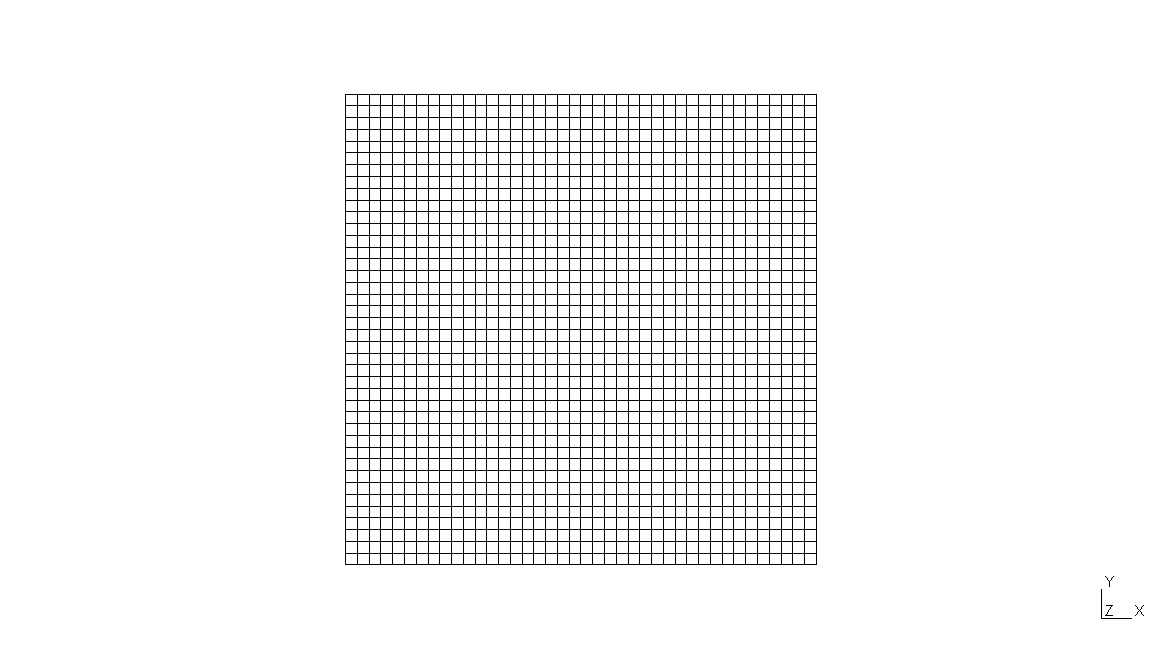

In [5]:
!gmsh ./pos/m.pos gscript
from IPython.core.display import Image
Image('./png/m.png')


境界条件は底面にインピーダンスを考慮したダンパー境界(水平方向$\rho V_S A$、上下方向$\rho V_P A$)を設け、側面部分には水平ローラーを設けます。ただし、$A$は各ダンパーの担当面積を意味します。
今回定義が必要な側面と底面について面を定義しておきます。

In [6]:
P = m.pts()
cbot = (abs(P[1,:]-0.000e+00) < 1.000e-6)
cright = (abs(P[0,:]-x) < 1.000e-6)
cleft = (abs(P[0,:]-0.000e+00) < 1.000e-6)

pidbot = np.compress(cbot,range(0,m.nbpts()))
pidright = np.compress(cright,range(0,m.nbpts()))
pidleft = np.compress(cleft,range(0,m.nbpts()))

fbot = m.faces_from_pid(pidbot)
fright = m.faces_from_pid(pidright)
fleft = m.faces_from_pid(pidleft)

BOTTOM = 1
RIGHT = 2
LEFT = 3
SIDE = 4
m.set_region(BOTTOM, fbot)
m.set_region(RIGHT,fright)
m.set_region(LEFT,fleft)

m.set_region(SIDE,[[],[]])
m.region_merge(SIDE,RIGHT)
m.region_merge(SIDE,LEFT)
